<div style="border:solid green 2px; padding: 20px">
<b>Комментарий ревьюера:</b> 
    
Александр, привет! Меня зовут Бунакова Влада. Если не возражаешь, предлагаю общаться на «ты» :)
    <div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Привет, Влада! На "ты" - ок)
</div>  

Ниже в файле ты найдешь мои комментарии: <font color='green'>зеленый цвет — «все отлично»; </font> <font color='orange'>желтый — «хорошо, но можно лучше (один-два таких замечаний допустимы, но если их больше — придется исправлять)»; </font> <font color='red'>красный — «нужно исправить».</font> Комментарии в самом коде я отделяю знаками «###». Пожалуйста, не удаляй мои комментарии, они мне нужны при повторной проверке. Будет здорово, если в своих новых комментариях (выделяй их другим цветом) ты напишешь о сделанных тобой изменениях в коде. 


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
авторы проекта изменили исходные дата-сеты
</div> 

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

В df_test теперь нет столбцов *adr, price, assighned_room, assigned_room_type, agent, company*  поэтому действия с этими столбцами закоментированны 
</div> 

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
Дата-сеты разделены: трэйн - 2015-2016 года, тест - 2017 год
</div> 

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Результаты вычислений после исправлений изменились
</div> 

# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик исследования — сеть отелей «Как в гостях».
Заказчик добавил на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменяет бронирование, то компания терпет убытки.
+ **Задача:**
+ Разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.
+ *Дополнительные условия:*
+ В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
+ На разработку системы прогнозирования заложен бюджет — 400 000 руб. При этом необходимо учесть, что внедрение модели должно окупиться. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

## . Откройте файлы с данными

Загружаем нужные библиотеки:

In [224]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm
import random
from itertools import chain
from matplotlib import pyplot
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

Открываем файлы от заказчика:

У нас имеется два дата-сета: первый для обучения модели, назовем его *df*; второй для итогового тестирования разработанной модели, назовем его *df_test*. По последней информации от заказчика столбцы *adr* и *price* нерелевантны. Поэтому сразу удалим их из дата-сетов:

In [68]:
df = pd.read_csv('/datasets/hotel_train.csv')
df_test = pd.read_csv('/datasets/hotel_test.csv')
#df = df.drop(['adr', 'price'], axis=1)
#df_test = df_test.drop(['adr', 'price'], axis=1)
display(df.head(2))
display(df_test.head(2))

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4


**Вывод:** данные успешно загружены.

Посмотрим общую информацию о данных:

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
id                                65229 non-null int64
is_canceled                       65229 non-null int64
lead_time                         65229 non-null float64
arrival_date_year                 65229 non-null int64
arrival_date_month                65229 non-null object
arrival_date_week_number          65229 non-null int64
arrival_date_day_of_month         65229 non-null int64
stays_in_weekend_nights           65229 non-null int64
stays_in_week_nights              65229 non-null int64
adults                            65229 non-null float64
children                          65229 non-null float64
babies                            65229 non-null float64
meal                              65229 non-null object
country                           65229 non-null object
distribution_channel              65229 non-null object
is_repeated_guest                 65229 non-null int64

**Вывод**: Дата-сет имеет 32417 строк и 29 колонок. В некоторых колонках имеются пропуски. Для работы моделей нам нужно будет заполнить их.

In [70]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
id                                32412 non-null int64
is_canceled                       32412 non-null int64
lead_time                         32412 non-null float64
arrival_date_year                 32412 non-null int64
arrival_date_month                32412 non-null object
arrival_date_week_number          32412 non-null int64
arrival_date_day_of_month         32412 non-null int64
stays_in_weekend_nights           32412 non-null int64
stays_in_week_nights              32412 non-null int64
adults                            32412 non-null float64
children                          32412 non-null float64
babies                            32412 non-null float64
meal                              32412 non-null object
country                           32412 non-null object
distribution_channel              32412 non-null object
is_repeated_guest                 32412 non-null int64

<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера ⚠️</b> 

Не хватает вывода: есть ли пропуски в тестовой выборке?
</div>


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Я смотрю пропуски по методу info(). Ну можно и так:
</div>  

In [71]:
df_test.isna().mean()

id                                0.0
is_canceled                       0.0
lead_time                         0.0
arrival_date_year                 0.0
arrival_date_month                0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_weekend_nights           0.0
stays_in_week_nights              0.0
adults                            0.0
children                          0.0
babies                            0.0
meal                              0.0
country                           0.0
distribution_channel              0.0
is_repeated_guest                 0.0
previous_cancellations            0.0
previous_bookings_not_canceled    0.0
reserved_room_type                0.0
booking_changes                   0.0
days_in_waiting_list              0.0
customer_type                     0.0
required_car_parking_spaces       0.0
total_of_special_requests         0.0
total_nights                      0.0
dtype: float64

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Отлично, загрузили данные и удалили ненужные столбцы.
</div>


## . Предобработка и исследовательский анализ данных

### Обработка дубликатов:

In [72]:
print('Количество дубликатов в дата-сете: ', df.duplicated().sum())

Количество дубликатов в дата-сете:  0


**Вывод:** мы видим очень много дубликатов в дата-сете. Но мы их удалять не будем, так как они появились не случайно и не по ошибке. Например пять человек приехали из одной компании в командировку и сняли 5 одинаковых номеров на один срок. Таким образом появляются дубликаты, но это разные люди.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Да, такое возможно.
</div>


### Предобработка полей с пропусками:

Посмотрим числовое описание колонки *lead_time* — количество дней между датой бронирования и датой прибытия;. В колонке имеются пропуски.

In [73]:
print('Доля пропусков в колонке lead_time:', df['lead_time'].isna().mean())
df['lead_time'].describe()

Доля пропусков в колонке lead_time: 0.0


count    65229.000000
mean        96.337917
std         96.127545
min          0.000000
25%         17.000000
50%         64.000000
75%        151.000000
max        374.000000
Name: lead_time, dtype: float64

**Вывод:**:  Видим,что все значения адекватны. Медиана равна 48, этим значением и заполним пропуски.  

Заполним пропуски в колонке lead_time значением 48:

In [74]:
df['lead_time'] = df['lead_time'].fillna(48)
print('Доля пропусков в колонке lead_time после заполнения пропусков:', df['lead_time'].isna().mean())

Доля пропусков в колонке lead_time после заполнения пропусков: 0.0


Посмотрим числовое описание колонки *adults* — количество взрослых постояльцев; В ней имеются пропуски.

In [75]:
print('Доля пропусков в колонке adults:', df['adults'].isna().mean())
df['adults'].describe()

Доля пропусков в колонке adults: 0.0


count    65229.000000
mean         1.836576
std          0.480245
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: adults, dtype: float64

**Вывод:** В колонке adults - все значения адекватны. Медиана равна 2. Запоним ей пропуски:

Заполним пропуски в колонке *adults* значением 2:

In [76]:
df['adults'] = df['adults'].fillna(2)
print('Доля пропусков в колонке adults после заполнения пропусков:', df['adults'].isna().mean())

Доля пропусков в колонке adults после заполнения пропусков: 0.0


Посмотрим числовое описание колонки *children*  — количество детей от 3 до 14 лет; В этой колоке имеются пропуски: 

In [77]:
print('Доля пропусков в колонке children:', df['children'].isna().mean())
df['children'].describe()

Доля пропусков в колонке children: 0.0


count    65229.000000
mean         0.074890
std          0.334243
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: children, dtype: float64

**Вывод:** Процент пропусков примерно 4,6%. Числовое описание нам ничего не дало, мы видим только, что максимальное значение равно 3. Медиана = 0.

Посмотрим уникальные значения и их количество колонки *children*:

In [78]:
df['children'].value_counts(dropna = False)

0.0    61712
1.0     2165
2.0     1336
3.0       16
Name: children, dtype: int64

**Вывод:** самое часто встречающееся значение 0. Им заполним пропуски:

In [79]:
df['children'] = df['children'].fillna(0)
print('Доля пропусков в колонке children, после заполнения пропусков:', df['children'].isna().mean())

Доля пропусков в колонке children, после заполнения пропусков: 0.0


Посмотрим уникальные значения колонки babies - количество младенцев; В этой колонке имеются пропуски.

In [80]:
df['babies'].value_counts(dropna = False)

0.0     64777
1.0       447
2.0         3
10.0        1
9.0         1
Name: babies, dtype: int64

**Вывод:** самое часто встречающееся значение 0. Заполним им пропуски:

In [81]:
df['babies'] = df['babies'].fillna(0)
print('Доля пропусков в колонке babies, после заполнения пропусков:', df['babies'].isna().mean())

Доля пропусков в колонке babies, после заполнения пропусков: 0.0


Посмотрим уникальные значения колонки *meal* — опции заказа:
SC — нет дополнительных опций;
BB — включён завтрак;
HB — включён завтрак и обед;
FB — включён завтрак, обед и ужин.  В этой колонке имеются пропуски:

In [82]:
df['meal'].value_counts(dropna=False)

BB           51697
HB            7292
SC            5274
SC             515
FB             451
Name: meal, dtype: int64

**Вывод:** Самое часто стречающееся значение - BB. Заполним им пропуски:

<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера ⚠️</b> 

Ниже ты удаляешь пропуски, а не заполняешь их. Обнови вывод.
</div>


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Не понял: Что значит обновить вывод? Что именно вывести?
</div>  

Заполним пропуски в колонке *meal* пустым значением, и удалим эти строки из дата-сета:

In [83]:
df['meal'] = df['meal'].astype("str")
df['meal'] = df['meal'].str.strip()
df['meal'] = df['meal'].replace("nan" , "")
df = df.query('meal != ""')
print('Количество объектов после удаления пропусков в колонке meal:', len(df))

Количество объектов после удаления пропусков в колонке meal: 65229


In [84]:
df['meal'].value_counts(dropna=False)

BB    51697
HB     7292
SC     5789
FB      451
Name: meal, dtype: int64

Посмотрим на уникальные значения в колонке *distribution_channel*:

In [85]:
df['distribution_channel'].value_counts(dropna=False)

TA/TO        54454
Direct        6853
Corporate     3823
GDS             99
Name: distribution_channel, dtype: int64

**Вывод:** все значения адекватны. Пропуски заполним значением "TA/TO".

In [86]:
df['distribution_channel'] = df['distribution_channel'].astype("str")
df['distribution_channel'] = df['distribution_channel'].replace("nan", "TA/TO")
print('Доля пропусков в колонке distribution_channel, после заполнения пропусков:', df['meal'].isna().mean())

Доля пропусков в колонке distribution_channel, после заполнения пропусков: 0.0


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Прекрасно, все пропуски обработаны корректно.
</div>


### Предобработка полей без пропусков:

В колонке *is_canceled* пропусков нет. Посмотрим уникальные значения этого признака:

In [87]:
df['is_canceled'].value_counts(dropna = False)

0    41185
1    24044
Name: is_canceled, dtype: int64

**Вывод:** в колонке имются два уникальных значения "0" и "1". "1" означает, что клиент отменил заказ. 

Посмотрим уникальные значения в колонке *arrival_date_year*:

In [88]:
df['arrival_date_year'].value_counts()

2016    46901
2015    18328
Name: arrival_date_year, dtype: int64

**Вывод:** в тренировочном дата-сете мы имеем данные за 3 года.

Посмотрим уникальные значения колонки *arrival_date_year* тестового дата-сета:

In [89]:
df_test['arrival_date_year'].value_counts()

2017    32412
Name: arrival_date_year, dtype: int64

**Вывод:** в тестовом дата-сете данные за те же 3 года.

Посмотрим уникальные значения в колонке arrival_date_month:

In [90]:
print('Уникальные значения месяцев: ', df['arrival_date_month'].value_counts())
print('Количество уникальных месяцев: ', len(df['arrival_date_month'].value_counts()))

Уникальные значения месяцев:  October      9255
September    8782
August       6678
November     5761
July         5718
December     5497
April        4804
May          4677
June         4659
March        4148
February     3358
January      1892
Name: arrival_date_month, dtype: int64
Количество уникальных месяцев:  12


**Вывод:** мы имеем данные за все 12 месяцев в году.

Посмотрим уникальные значения в колонке arrival_date_week_number:

In [91]:
print('Уникальные значения порядкового номера недели в году: ', df['arrival_date_week_number'].unique())
print('Количество уникальных значений порядковых номеров недель в году: ', len(df['arrival_date_week_number'].value_counts()))

Уникальные значения порядкового номера недели в году:  [27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25 26]
Количество уникальных значений порядковых номеров недель в году:  53


**Вывод:** максимальное количество недель в году - 53.

Посмотрим уникальные значения в колонке *arrival_date_day_of_month*:

In [92]:
print('Уникальные значения порядковых номеров дней в месяце: ', df['arrival_date_day_of_month'].unique())
print('Количество уникальных значений порядковых номеров дней в месяце: ', len(df['arrival_date_day_of_month'].value_counts()))

Уникальные значения порядковых номеров дней в месяце:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
Количество уникальных значений порядковых номеров дней в месяце:  31


Посмотрим уникальные значения в колонке *stays_in_weekend_nights*:

In [93]:
print('Уникальные значения колонки "количество ночей в выходные дни" : ', df['stays_in_weekend_nights'].value_counts())

Уникальные значения колонки "количество ночей в выходные дни" :  0    29738
1    17721
2    17357
3      261
4      152
Name: stays_in_weekend_nights, dtype: int64


**Вывод:** все значения адекватны: от 0 до 4.

Посмотрим уникальные значения в колонке *stays_in_week_nights*:

In [94]:
print('Уникальные значения колонки "количество ночей в будние дни" : ', df['stays_in_week_nights'].value_counts())

Уникальные значения колонки "количество ночей в будние дни" :  2    20137
1    17850
3    12341
4     5131
5     5128
0     4007
6      635
Name: stays_in_week_nights, dtype: int64


**Вывод:** все значения адекватны: от 0 до 6.

Посмотрим уникальные значения в колонке *country*:

In [95]:
print('Количество уникальных значений колонки df[country] "гражданство постояльца" : ', df['country'].nunique())
print('Количество уникальных значений колонки df_test[country] "гражданство постояльца" : ', df_test['country'].nunique())

Количество уникальных значений колонки df[country] "гражданство постояльца" :  155
Количество уникальных значений колонки df_test[country] "гражданство постояльца" :  143


**Вывод:** количество уникальных значений в колонке *country* тестового набора данных больше на 46 значений.

Посмотрим уникальные значения в колонке *is_repeated_guest*:

In [96]:
print('Уникальные значения колонки "бронирует второй раз" : ', df['is_repeated_guest'].value_counts())

Уникальные значения колонки "бронирует второй раз" :  0    63458
1     1771
Name: is_repeated_guest, dtype: int64


**Вывод:** В колонке *is_repeated_guest* имеем две категории значений: 0 и 1.

Посмотрим уникальные значения в колонке *previous_cancellations*:

In [97]:
print('Уникальные значения колонки "количество отменённых заказов у клиента" : ', df['previous_cancellations'].value_counts())

Уникальные значения колонки "количество отменённых заказов у клиента" :  0     59591
1      5367
2        54
3        51
11       35
24       28
25       19
26       18
19       17
5        13
13       12
14       11
6         7
4         5
21        1
Name: previous_cancellations, dtype: int64


Посмотрим уникальные значения в колонке *previous_bookings_not_canceled*:

In [98]:
print('Уникальные значения колонки "количество подтвержденных заказов у клиента" : ', df['previous_bookings_not_canceled'].value_counts())

Уникальные значения колонки "количество подтвержденных заказов у клиента" :  0     63686
1       645
2       252
3       136
4       114
5        89
6        56
7        34
8        25
9        23
10       21
11       16
12       14
25       10
13        9
21        8
14        8
15        7
22        7
16        6
20        5
19        5
18        5
17        5
24        3
27        3
44        2
23        2
28        2
48        2
29        2
56        1
35        1
33        1
58        1
36        1
26        1
32        1
37        1
57        1
38        1
34        1
52        1
39        1
40        1
55        1
41        1
42        1
54        1
43        1
53        1
45        1
30        1
47        1
49        1
50        1
51        1
31        1
Name: previous_bookings_not_canceled, dtype: int64


**Вывод:** значения колонки "количество подтвержденных заказов у клиента" адекватны.

Посмотрим уникальные значения в колонке *reserved_room_type*:

In [99]:
print('Уникальные значения колонки "тип забронированной комнаты" df : ', df['reserved_room_type'].value_counts())
print('Уникальные значения колонки "тип забронированной комнаты" df_test : ', df_test['reserved_room_type'].value_counts())

Уникальные значения колонки "тип забронированной комнаты" df :  A                   50501
D                    9387
E                    2448
F                    1213
B                     860
G                     592
C                     228
Name: reserved_room_type, dtype: int64
Уникальные значения колонки "тип забронированной комнаты" df_test :  A                   23471
D                    6123
E                    1644
F                     503
G                     278
C                     201
B                     192
Name: reserved_room_type, dtype: int64


**Вывод:** в тестовом дата-сете df_test в колонке "reserved_room_type" нет значения "H", но это допустимо.В колонке "тип забронированной комнаты" df мы видим некорректное значение "L". Удалим эти строки из дата-сета df, их всего 6:

In [100]:
df['reserved_room_type'] = df['reserved_room_type'].str.strip()
df_test['reserved_room_type'] = df_test['reserved_room_type'].str.strip()
df = df.query('reserved_room_type != "L"')
print('Количество объектов в df после удаления строк с некорректными значениями колонки reserved_room_type: ', len(df))


Количество объектов в df после удаления строк с некорректными значениями колонки reserved_room_type:  65229


Посмотрим уникальные значения в колонке *assigned_room_type*:

In [101]:
#print('Уникальные значения колонки "тип предоставленной комнаты" df : ', df['assigned_room_type'].value_counts())
#print('Уникальные значения колонки "тип предоставленной комнаты" df_test : ', df_test['assigned_room_type'].value_counts())

**Вывод:** видим, что df имеется некорректное значение "I", а в df_test имеется "К".

Удалим значение "I" из df и "К" из df_test из колонки *assigned_room_type* - тип предоставленной комнаты:

In [102]:
#df['assigned_room_type'] = df['assigned_room_type'].str.strip()
#df_test['assigned_room_type'] = df_test['assigned_room_type'].str.strip()
#df = df.query('assigned_room_type != "I"')
#df_test = df_test.query('assigned_room_type != "K"')
#print('Количество объектов в df после удаления строк с  assigned_room_type == "I": ', len(df))
#print('Количество объектов в df_test после удаления строк с assigned_room_type == "К": ', len(df_test))

Посмотрим уникальные значения в колонке *booking_changes* - — количество изменений параметров заказа:

In [103]:
df['booking_changes'].value_counts()

0     56195
1      6615
2      1754
3       413
4       149
5        42
6        19
7        18
8         7
9         5
13        4
15        2
14        2
10        2
17        1
16        1
Name: booking_changes, dtype: int64

**Вывод:** все значения в колонке *booking_changes* корректны.

Посмотрим уникальные значения колонки *agent* - — агент, через которого сделан заказ:

In [104]:
#print('Уникальные значения колонки agent: ', df['agent'].unique())
#print('Количество уникальных значений колонки agent: ', df['agent'].nunique())

**Вывод:** все значения колонки *agent* - корректны. Общее количество уникальных - 174.

Посмотрим уникальные значения колонки *company* - — ID компании, ответственная за бронирование:

In [105]:
#print('Уникальные значения колонки company: ', df['company'].unique())
#print('Количество уникальных значений колонки company: ', df['company'].nunique())

Посмотрим уникальные значения колонки *days_in_waiting_list* — сколько дней заказ ожидал подтверждения:

In [106]:
df['days_in_waiting_list'].unique()

array([  0,  50,  47,  65, 122,  75, 101, 150, 125,  22, 142,   2,  13,
        44,  38,  48,  33,  77,  21,  80,  59,  40,  58,  89,  53,  49,
        60,  69,  87,  91,  57,  99, 111,  79,  98,  85,  63,  15,   3,
        20,  93,   4,  41,  34, 224,  31,  39,  56, 187, 176,  71,  55,
        96, 236, 259, 207, 215, 160, 120,  30,  32,  27,  62,  24, 108,
       147,   5,  14, 107,  70,   8,  35, 178, 174, 162,  68,  11, 193,
        10,  76,  17,  45,   6,  19,  28,  42,  25,  46,   9,   1,  43,
        72,  12,  61,  81,  74, 167])

**Вывод:** все значения колонки *days_in_waiting_list* корректны.

Посмотрим уникальные значения колонки *customer_type*  — тип заказчика:
*Contract* — договор с юридическим лицом;
*Group* — групповой заезд;
*Transient* — не связано с договором или групповым заездом;
*Transient-party* — не связано с договором или групповым заездом, но связано с бронированием типа Transient.:

In [107]:
df['customer_type'].value_counts()

Transient          45493
Transient-Party    16703
Contract            2746
Group                287
Name: customer_type, dtype: int64

In [108]:
df_test['customer_type'].value_counts()

Transient          27461
Transient-Party     4427
Contract             359
Group                165
Name: customer_type, dtype: int64

**Вывод:** все значения колонки customer_type корректны.

Посмотрим уникальные значения колонки *required_car_parking_spaces* — количество мест для автомобилей:

In [109]:
print('Уникальные значения колонки required_car_parking_spaces дата-сета df: ', df['required_car_parking_spaces'].value_counts())
print('Уникальные значения колонки required_car_parking_spaces дата-сета df_test:', df_test['required_car_parking_spaces'].value_counts())

Уникальные значения колонки required_car_parking_spaces дата-сета df:  0    61547
1     3670
2       11
3        1
Name: required_car_parking_spaces, dtype: int64
Уникальные значения колонки required_car_parking_spaces дата-сета df_test: 0    30935
1     1468
2        6
8        2
3        1
Name: required_car_parking_spaces, dtype: int64


**Вывод:** в df мы видим выбивающееся значение "8". Скорее всего это значение "3". Вывод уникальных значений этой же колонки из df_test нам это подтверждает.

Исправим значение "8" на "3" в колонке *required_car_parking_spaces* дата-сета df:

In [110]:
df.loc[(df.required_car_parking_spaces == 8), 'required_car_parking_spaces'] = 3
print('Уникальные значения колонки required_car_parking_spaces дата-сета df после замены выбивающего значения "8" на "3": ', df['required_car_parking_spaces'].value_counts())

Уникальные значения колонки required_car_parking_spaces дата-сета df после замены выбивающего значения "8" на "3":  0    61547
1     3670
2       11
3        1
Name: required_car_parking_spaces, dtype: int64


Посмотрим уникальные значения колонки *total_of_special_requests* — количество специальных отметок:

In [111]:
print(df['total_of_special_requests'].value_counts())

0    40671
1    16958
2     6444
3     1036
4      107
5       13
Name: total_of_special_requests, dtype: int64


**Вывод:** все значения в колонке *total_of_special_requests* корректны.

Посмотрим уникальные значения колонки *total_nights* - общее количество ночей:

In [112]:
df['total_nights'].value_counts()

2     16795
3     15652
1     12122
4      9629
5      4288
7      3853
6      2078
8       542
9       152
10      118
Name: total_nights, dtype: int64

**Вывод:** все значения колонки *total_nights* корректны.

В дата-сете имеются колонки *reserved_room_type* - категория забронированного номера и *assigned_room_type* - категория фактически предоставленной комнаты. Они совпадают не всегда:

In [113]:
#df_filt_room = df[['reserved_room_type', 'assigned_room_type']]
#display(df_filt_room.query('reserved_room_type != assigned_room_type').head())
#print('Доля объектов с несовпадающими "reserved_room_type" и "assigned_room_type": ', len(df_filt_room.query('reserved_room_type != assigned_room_type')) / len(df))

**Вывод:** Процент объектов с несовпадающими категорией забронированной комнаты и впоследствии предоставленной - 20 %. Эту особенность учтем в окончательной цене номера. 

Бывает так, что клиенту предоставили номер более высокой категории, чем забронированный:

In [114]:
#df_filt_room.query('reserved_room_type > assigned_room_type').head()

Бывает и наоборот - категорию понизили:

In [115]:
#df_filt_room.query('reserved_room_type < assigned_room_type').head()

**Вывод:** Ценообразование рассматриваемых объектов будет обосновано в разделе "Формулировка ML-задачи на основе бизнес-задачи".

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Исследовательский анализ исходных данных выполнен блестяще 👏👏👏
</div>


### Замена типов данных

В *df* и *df_test* имеются одни и те же данные, но разных типов, приведем отличающиеся типы данных в *df* к типам в *df_test*:

In [116]:
df['lead_time'] = df['lead_time'].astype('int64')
df['adults'] = df['adults'].astype('int64')
df['babies'] = df['babies'].astype('int64')
print('Тип данных в "df[lead_time]" :', df['lead_time'].dtype)
print('Тип данных в "df[adults]" :', df['adults'].dtype)
print('Тип данных в "df[babies]" :', df['babies'].dtype)

Тип данных в "df[lead_time]" : int64
Тип данных в "df[adults]" : int64
Тип данных в "df[babies]" : int64


### Расчет прибыли отеля до внедрения машинного обучения:

Расчет прибыли будем считать на дата-сете df_test, но для расчетов сохраним его в отдельной переменной df_profit:

In [117]:
df_profit = df_test

<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера ⚠️</b> 

Обрати внимание, при вызове
    
    df_profit = df_test
    
копирования датасета не происходит. Все изменения с df_profit будут отражаться и на df_test. Если бы ты ниже удалял столбцы с параметром inplace=True:
    
        df_profit.drop(['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'agent',
       'company', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests'], axis=1, inplace=True)
    
то автоматически столбцы удалялись бы и из df_test. Чтобы избежать ошибок подобного рода, для копирования датасета используй специальную функцию.

</div>



<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Я не хотел, чтобы изменения в df_profit, от отражались бы на df_test. Так я в итоге правильно сделал?
</div>  

Оставим в df_profit только те колонки, которые пригодятся нам для расчета прибыли, остальные удалим:

In [118]:
df_profit = df_profit.drop(['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes',
       'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests'], axis=1).reset_index()


In [119]:
display(df_profit.head(2))

,index,id,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights
0,0,6086,1,2017,January,1,1,A,1
1,1,6087,1,2017,January,1,1,A,4


По заданным условиям рассмотрим внимательнее: из чего состоит итоговая прибыль отеля. В самом упрощенном варианте это формула: "Прибыль"(profit) = "Доход"(income) - "Расход"(cost). Будем рассматривать два варианта: is_canceled == 0 - клиент воспользовался забронированным номером и заселился и is_canceled == 1 - клиент снял бронь или не явился в день заселения. Рассчитаем отдельно из чего складывается "Доход"(income) = Стоимость номера в зависимости от категории(price_of_nights) * сезонный коэфициент(coef_seas) * количество ночей(total_nights). Расход состоит из двух составляющих: "Расход"(cost) = "Затраты на приготовление номера"(one_time_cost) + "Затраты на уборку каждые 2 дня"(period_cost). "Затраты на уборку каждые 2 дня"(period_cost) присутствуют если постоялец снял номер больше чем на 2 ночи. Запишем итоговую формулу расчета прибыли отеля:
+ *Для is_canceled == 0* :  "Прибыль"(profit) = (Стоимость номера в зависимости от категории(price_of_nights) * сезонный коэфициент(coef_seas) * количество ночей(total_nights)) - ("Затраты на приготовление номера"(one_time_cost) + "Затраты на уборку каждые 2 дня"(period_cost))
+ *Для is_canceled == 1* : "Доход"(income) = 0; "Затраты на приготовление номера"(one_time_cost) = какой-то величине, в зависимости от категории номера; "Затраты на уборку каждые 2 дня"(period_cost) = 0.

Создадим словарь *coef_seas*, в котором месяц соответствует сезонному коэффициенту стоимости номера и словарь, в котором категории номера соответствую стоимость номера и расходы на его обслуживание:

In [120]:
coef_seas = pd.DataFrame({'arrival_date_month': ['January', 'February', 'March', 'April', 'May', 'June',

'July', 'August', 'September','October', 'November', 'December'],

'coef_seas': [1.0, 1.0, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4, 1.2, 1.2, 1.2, 1.0],

'n_month': [1,2,3,4,5,6,7,8,9,10,11,12]})
categ_price = pd.DataFrame({'reserved_room_type': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],

'price_of_nights': [1000, 800, 600, 550, 500, 400, 350, 300],

'one_time_cost': [400, 250, 250, 150, 150, 150, 150, 100]})
display(coef_seas)
display(categ_price)

,arrival_date_month,coef_seas,n_month
0,January,1.0,1
1,February,1.0,2
2,March,1.2,3
3,April,1.2,4
4,May,1.2,5
5,June,1.4,6
6,July,1.4,7
7,August,1.4,8
8,September,1.2,9
9,October,1.2,10


,reserved_room_type,price_of_nights,one_time_cost
0,A,1000,400
1,B,800,250
2,C,600,250
3,D,550,150
4,E,500,150
5,F,400,150
6,G,350,150
7,H,300,100


Добавим в df_profit полученные словари:

In [121]:
df_profit = df_profit.merge(coef_seas, on='arrival_date_month', how='left')
df_profit = df_profit.merge(categ_price, on='reserved_room_type', how='left')
display(df_profit.head(2))

,index,id,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights,coef_seas,n_month,price_of_nights,one_time_cost
0,0,6086,1,2017,January,1,1,A,1,1.0,1,1000,400
1,1,6087,1,2017,January,1,1,A,4,1.0,1,1000,400


Добавим новый столбец *income*, в котором рассчитаем доход для каждого объекта:

In [122]:
# так как в объектах для is_canceled == 1 имеются значения в признаках total_nights отличные от нуля,
# сделаем это через цикл
income = []
is_canceled_list = list(df_profit['is_canceled'])
reserved_room_type_list = list(df_profit['reserved_room_type'])
price_of_nights_list = list(df_profit['price_of_nights'])
coef_seas_list = list(df_profit['coef_seas'])
total_nights_list = list(df_profit['total_nights'])
for index in range(len(is_canceled_list)):
    if is_canceled_list[index] == 0:
        income.append(price_of_nights_list[index] * coef_seas_list[index] * total_nights_list[index]) 
    else: #is_canceled_list[index] == 1
        income.append(0)
df_profit['income'] = income     
   

In [123]:
display(df_profit.query('is_canceled == 0').head(2))
display(df_profit.query('is_canceled == 1').head(2))

,index,id,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights,coef_seas,n_month,price_of_nights,one_time_cost,income
95,95,6184,0,2017,January,4,25,A,1,1.0,1,1000,400,1000.0
299,299,6391,0,2017,February,8,22,A,4,1.0,2,1000,400,4000.0


,index,id,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights,coef_seas,n_month,price_of_nights,one_time_cost,income
0,0,6086,1,2017,January,1,1,A,1,1.0,1,1000,400,0.0
1,1,6087,1,2017,January,1,1,A,4,1.0,1,1000,400,0.0


**Вывод:** столбец *income* рассчитан верно.

Добавим столбец *period_cost*, в котором рассчитаем затраты на уборку для постояльцев, заселившихся на более чем 2 ночи.

In [125]:
# так как в объектах для is_canceled == 1 имеются значения в признаках total_nights отличные от нуля,
# сделаем это через цикл
period_cost = []
is_canceled_list = list(df_profit['is_canceled'])
one_time_cost_list = list(df_profit['one_time_cost'])
total_nights_list = list(df_profit['total_nights'])
for index in range(len(is_canceled_list)):
    if is_canceled_list[index] == 0:
        period_cost.append(one_time_cost_list[index] *
                           (np.where((total_nights_list[index]) <= 2, 0,
                                         np.floor(total_nights_list[index] / 2)))) 
      
    else:
        period_cost.append(0)
df_profit['period_cost'] = period_cost 

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Так как при расчете period_cost ты используешь «np.where((total_nights_list[index]) <= 2, 0,...)», то условие
    
    if total_nights_list[index]>2
    
можно убрать.
    
</div>


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Согласен! Убрал  if total_nights_list[index]>2
</div>  

In [126]:
display(df_profit.query('is_canceled == 0').head(2))
display(df_profit.query('is_canceled == 1').head(2))

,index,id,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights,coef_seas,n_month,price_of_nights,one_time_cost,income,period_cost
95,95,6184,0,2017,January,4,25,A,1,1.0,1,1000,400,1000.0,0.0
299,299,6391,0,2017,February,8,22,A,4,1.0,2,1000,400,4000.0,800.0


,index,id,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights,coef_seas,n_month,price_of_nights,one_time_cost,income,period_cost
0,0,6086,1,2017,January,1,1,A,1,1.0,1,1000,400,0.0,0.0
1,1,6087,1,2017,January,1,1,A,4,1.0,1,1000,400,0.0,0.0


**Вывод:** Столбец затрат на периодическое обслуживание period_cost рассчитан верно.

Добавим столбец profit_before расчета прибыли без внедрения ML:

In [127]:
df_profit['profit_before'] = df_profit['income'] - (df_profit['one_time_cost'] + df_profit['period_cost'])
display(df_profit.query('is_canceled == 0').head(2))
display(df_profit.query('is_canceled == 1').head(2))

,index,id,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights,coef_seas,n_month,price_of_nights,one_time_cost,income,period_cost,profit_before
95,95,6184,0,2017,January,4,25,A,1,1.0,1,1000,400,1000.0,0.0,600.0
299,299,6391,0,2017,February,8,22,A,4,1.0,2,1000,400,4000.0,800.0,2800.0


,index,id,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights,coef_seas,n_month,price_of_nights,one_time_cost,income,period_cost,profit_before
0,0,6086,1,2017,January,1,1,A,1,1.0,1,1000,400,0.0,0.0,-400.0
1,1,6087,1,2017,January,1,1,A,4,1.0,1,1000,400,0.0,0.0,-400.0


**Вывод:** столбец profit_before рассчитан верно.

Рассчитаем суммарную прибыль отеля за все время до внедрения ML:


In [128]:
total_profit_before = df_profit['profit_before'].sum()
print('Суммарная прибыль отеля до внедрения ML:', total_profit_before)

Суммарная прибыль отеля до внедрения ML: 47664770.0


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Прибыль рассчитана абсолютно верно 👍    
</div>


## Формулировка ML-задачи на основе бизнес-задачи

### Общее описание задачи

Опишем сегодняшнюю бизнес-ситуацию в гостинице без внедрения депозитов и технологий машинного обучения. Гостиница добавила на свой сайт новую услугу - бронирование номеров без предоплаты. В случае отказа клиентом от брони(таких клиентов около 27%) компания терпит убытки - это затраты на приготовление номера(сумма разового обслуживания) и упущенная прибыль(отказ в заселении другим людям на забронированные даты). Компания хочет защить себя от таких убытков. В данной работе мы будем учитывать убыток только ввиде разового обслуживания.

+ Наша задача: на основе тренировочных данных предсказать на тестовых данных отказ клиента от брони. Тем клиентам, кому мы предсказали высокую вероятность отказа от брони выставляется счет на оплату 80% от стоимости номера за первые сутки. Внесение этого депозита - объязательное условие бронирования для таких клиентов. В случае, если бронь будет отменена, то депозит не возвращается. Если же этот клиент воспользуется забронированым номером - депозит пойдет в счет его оплаты. 
+ Модель конечно не идеальна и совершает ошибки. Их можно разделить на 2 рода:
  + FP - ложно-положительные - мы забронировали номер Надежному клиенту с внесением депозита (Надежный клиент - это клиент, уверенный в своем выборе, уверен, что его поездка состоится, и он не планирует отменять бронь). В этом случае мы предполагаем, что предложение Надежному клиенту о внесении депозита  не повлечет за собой его отказ от услуг бронирования номера. Так как, если его поездка состоится - он ничего не потеряет.
  + FN - ложно-отрицательные - мы забронировали номер без внесения депозита Ненадежному клиенту (Ненадежный клиент - это клиент, который не уверен, что его поездка состоится, или он бронирует несколько номеров в разных гостиницах, чтобы выбрать в последствии один из них,  ввиду новых условий, открывшихся для него). В этом случае мы терпим убыток в размере суммы разового обслуживания. 
+ Случаи, когда модель предсказала верно:
  + TP - истинно-положительные - мы забронировали номер Ненадежному клиенту с внесением депозита. В этом случае, если клиент откажется - у нас не будет убытка, а даже небольшая прибыль в размере: "Стоимость номера" х 0,8 - "Разовое обслуживание".
  + TN - истинно-отрицательные - мы забронировали номер Надежному клиенту без предложения о внесении депозита. В этом случае мы ничего не теряем, так как Надежный клиент воспользуется забронированным номером с высокой вероятностью.

Стоимость номеров отеля и затраты на их обслуживание, руб:
+ категория A: за ночь — 1 000, разовое обслуживание — 400;
+ категория B: за ночь — 800, разовое обслуживание — 250;
+ категория C: за ночь — 600, разовое обслуживание — 250;
+ категория D: за ночь — 550, разовое обслуживание — 150;
+ категория E: за ночь — 500, разовое обслуживание — 150;
+ категория F: за ночь — 400, разовое обслуживание — 150;
+ категория G: за ночь — 350, разовое обслуживание — 150;
+ категория H: за ночь — 300, разовое обслуживание — 100.

На суточную стоимость номеров влияют сезонные коэффициенты:
+ зима - 1,0
+ весна - 1,2
+ осень - 1,2
+ лето - 1,4

На разработку данной системы прогнозирования выделен бюджет - 400000 руб. Система должна окупиться за 1 год. Рассчеты окупаемости будем проводить на 2017 году тренировочного дата-сета(df_test). Мы рассчитаем два варианта возможного развития событий: с внедрением системы прогнозирования отказа от брони и без неё. И на разнице прибылей посмотрим эффективность нашей системы. 

Рассмотрим два варианта рассчета экономической эффективности системы прогнозирования(ML):
+ Оптимистичный - предложение внесения депозита не влияет на отток клиентов.
+ Пессимистичный - предложение внесения депозита влечёт отток 75% клиентов.

###  Разработка модели ML

#### Разбиение данных на выборки:

Разобъем дата-сет *train_all* на обучающую и валидационную выборки в соотношении 0,75 на 0,25:

In [129]:
train, valid = train_test_split(df, test_size=0.25, random_state=12)
print('Количество объектов в тренировочной выборке: ', len(train))
print('Количество объектов в валидационной выборке: ',len(valid))

Количество объектов в тренировочной выборке:  48921
Количество объектов в валидационной выборке:  16308


#### Определение целевого и обучающих признаков:

Так как нам нужно предсказать отмену брони - целевым признаком будет колонка *is_canceled*. Остальное - обучающие признаки:

In [130]:
features_train = train.drop(['is_canceled'], axis=1) 
target_train = train['is_canceled']
features_valid = valid.drop(['is_canceled'], axis=1) 
target_valid = valid['is_canceled']
features_test = df_test.drop(['is_canceled'], axis=1) 
target_test = df_test['is_canceled']
print('Размерность фичей тренировочной выборки: ', features_train.shape)
print('Размерность target тренировочной выборки: ', target_train.shape)
print('Размерность фичей валидационной выборки: ', features_valid.shape)
print('Размерность фичей валидационной выборки: ', target_valid.shape)
print('Размерность фичей тестовой выборки: ', features_test.shape)
print('Размерность фичей тестовой выборки: ', target_test.shape)

Размерность фичей тренировочной выборки:  (48921, 24)
Размерность target тренировочной выборки:  (48921,)
Размерность фичей валидационной выборки:  (16308, 24)
Размерность фичей валидационной выборки:  (16308,)
Размерность фичей тестовой выборки:  (32412, 24)
Размерность фичей тестовой выборки:  (32412,)


#### Оценка баланса классов:

In [131]:
target_train.value_counts(normalize=True)

0    0.632101
1    0.367899
Name: is_canceled, dtype: float64

**Вывод:** Соотношение классов в целевом признаке примерно 70/30. Мы имеем дисбаланс классов.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Правильно, наблюдается дисбаланс.
</div>


#### Загрузка CatBoost и предсказание результатов:

В разделе предобработка данных мы увидели большую разницу в количестве уникальных значений категориального признака *country*: в тестовом наборе их на 46 больше. Если мы будем применять One_Hot_Encoder, то он после преобразовавния увеличит количество признаков в тестовом дата-сете на 46. Обычные модели не справятся с незнакомыми значениями и выдадут ошибку. Поэтому будем использовать модель Catboost, ей не требуется перед обучением предварительная обработка OHE. 

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера ❌</b> 

Нет, настройка (fit) OneHotEncoder проводится только по обучающей выборке, к тестовой выборке применяется метод transform. Поэтому число столбцов в обучающей и тестовой выборке будет совпадать. Да, число категорий на тестовой выборке больше, чем на обучающей. В случае, если на тесте встречается новая категория (которой не было на обучении), все соответствующие OHE-столбцы будут содержать нули (см. параметр handle_unknown у OneHotEncoder). Поэтому провести OHE-кодирование, на самом деле, ничего не мешает :)
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Провел OHE-кодирование на модели Случайный лес.
</div>  

In [220]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(features_train)
features_train_ohe = ohe.transform(features_train)
features_test_ohe = ohe.transform(features_test)


In [233]:
model_ohe = RandomForestClassifier(random_state=12, class_weight = 'balanced')

In [237]:
model_ohe.fit(features_train_ohe, target_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=12, verbose=0, warm_start=False)

In [238]:
predict_ohe = model_ohe.predict(features_test_ohe)
print(predict_ohe)

[0 0 0 ... 0 0 0]


In [239]:
auc_roc_ohe = metrics.roc_auc_score(target_test, model_ohe.predict_proba(features_test_ohe)[:, 1])

print(auc_roc_ohe)

0.7347803004470024


**Вывод:** OHE- кодирование завершено с результатом auc_roc_ohe = 0.7347803004470024

Установим Catboost:

In [132]:
# ! pip install catboost

Создадим модель, учитывая дисбаланс классов. В качестве метрики выберем ROC_AUC:

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Да, метрика AUC-ROC подходит для несбалансированных классов.
</div>


In [133]:
model = CatBoostClassifier(random_state = 12, verbose=100, class_weights= [0.73, 0.27])

Создадим переменную *params*, в которой сохраним интересующие нас гиперпараметры и диапазон их подбора:

In [134]:
params = {'depth': [4, 7, 10],
          'learning_rate': [0.03, 0.1, 0.15],
          'l2_leaf_reg': [1, 4, 9],
          'iterations': [300, 500]}

Создадим список категорильных переменных:

In [143]:
cat_features = ['arrival_date_month', 'meal', 'country', 'distribution_channel',
                   'reserved_room_type', 'customer_type']

Создадим модель для подбора оптимальных гиперпараметров по методу GridSearch:

In [136]:
# gs_model = GridSearchCV(model, params, scoring="roc_auc",  cv = 3, n_jobs= -1)

In [138]:
# гипрепараметры подобраны, поэтому ячейка закоментирована
# gs_model.fit(features_train, target_train,
         #eval_set = (features_valid, target_valid),
         #cat_features = cat_features)

bestTest = 0.9619137105
bestIteration = 999


<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера ⚠️</b> 

Закомментируй всю ячейку выше, чтобы не возникало ошибки.
</div>


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Закоментировал!
</div>  

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 
    
Гиперпараметры подбираются корректно, отлично!
</div>


In [139]:
#print(gs_model.best_score_)
#print(gs_model.best_params_)

In [140]:
print('Результат лучшей модели в поиске по GridSearch:',  0.9605877368131585)
print('Гиперпараметры подобранные по GridSearch:', {'depth': 10, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.03})

Результат лучшей модели в поиске по GridSearch: 0.9605877368131585
Гиперпараметры подобранные по GridSearch: {'depth': 10, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.03}


In [141]:
model_best = CatBoostClassifier(random_state=12, verbose=100, depth= 10, iterations= 1200,
                                l2_leaf_reg= 1, learning_rate= 0.01, class_weights= [0.73, 0.27],
                               eval_metric='AUC')

In [144]:
model_best.fit(features_train, target_train,
         eval_set = (features_valid, target_valid),
         cat_features = cat_features)

0:	test: 0.9619558	best: 0.9619558 (0)	total: 832ms	remaining: 16m 37s
100:	test: 0.9943299	best: 0.9943299 (100)	total: 1m 15s	remaining: 13m 44s
200:	test: 0.9954609	best: 0.9954609 (200)	total: 2m 32s	remaining: 12m 39s
300:	test: 0.9959451	best: 0.9959451 (300)	total: 3m 49s	remaining: 11m 25s
400:	test: 0.9962164	best: 0.9962164 (400)	total: 5m 4s	remaining: 10m 5s
500:	test: 0.9964128	best: 0.9964128 (500)	total: 6m 15s	remaining: 8m 44s
600:	test: 0.9965388	best: 0.9965388 (600)	total: 7m 26s	remaining: 7m 25s
700:	test: 0.9966488	best: 0.9966488 (700)	total: 8m 40s	remaining: 6m 10s
800:	test: 0.9967505	best: 0.9967505 (800)	total: 9m 53s	remaining: 4m 55s
900:	test: 0.9968243	best: 0.9968243 (900)	total: 11m 9s	remaining: 3m 42s
1000:	test: 0.9968816	best: 0.9968816 (1000)	total: 12m 24s	remaining: 2m 27s
1100:	test: 0.9969310	best: 0.9969310 (1100)	total: 13m 38s	remaining: 1m 13s
1199:	test: 0.9969962	best: 0.9969964 (1198)	total: 14m 53s	remaining: 0us

bestTest = 0.9969964

In [145]:
predict = model_best.predict(features_test)
print(predict)

[1. 0. 0. ... 0. 0. 0.]


In [146]:
auc_roc = metrics.roc_auc_score(target_test, model_best.predict_proba(features_test)[:, 1])

print(auc_roc)

0.9971612603438532


In [147]:
print('AUC_ROC наилучшей модели:', 0.9971612603438532)

AUC_ROC наилучшей модели: 0.9971612603438532


Добавим новый столбец в дата-фрейм **df_profit**, который будет показывать предсказание моделью отмены брони. Назовем его *predict*:

In [148]:
predict = predict.astype('int64')
df_profit['predict'] = predict
display(df_profit.head(2))

,index,id,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights,coef_seas,n_month,price_of_nights,one_time_cost,income,period_cost,profit_before,predict
0,0,6086,1,2017,January,1,1,A,1,1.0,1,1000,400,0.0,0.0,-400.0,1
1,1,6087,1,2017,January,1,1,A,4,1.0,1,1000,400,0.0,0.0,-400.0,0


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Ок, все правильно, переходим к следующему шагу.
</div>


### Рассчет прибыли после внедрения ML:

#### Оптимистичный сценарий:

Рассчитаем доход после внедрения модели обучения при "Оптимистичном сценарии". Напомним, что при "Оптимистичном сценарии" мы приняли условие отсутствия оттока клиентов при предложении им внесения депозита.  Создадим столбец *income_ml_opti* и рассчитаем в нем доход для каждого объекта:

In [149]:
income_ml_opti = []
is_canceled_list = list(df_profit['is_canceled'])
reserved_room_type_list = list(df_profit['reserved_room_type'])
price_of_nights_list = list(df_profit['price_of_nights'])
coef_seas_list = list(df_profit['coef_seas'])
total_nights_list = list(df_profit['total_nights'])
predict_list = list(df_profit['predict'])
for index in range(len(is_canceled_list)):
    if ((is_canceled_list[index] == 0) & (predict_list[index] == 1)):
        income_ml_opti.append(price_of_nights_list[index] * coef_seas_list[index] * total_nights_list[index])
    elif ((is_canceled_list[index] == 1) & (predict_list[index] == 0)):
        income_ml_opti.append(0)
    elif ((is_canceled_list[index] == 1) & (predict_list[index] == 1)):
        income_ml_opti.append(price_of_nights_list[index] * 0.8)
    else: # (is_canceled_list[index] == 0) & (predict_list[index] == 0)
        income_ml_opti.append(price_of_nights_list[index] * coef_seas_list[index] * total_nights_list[index])
        
        
       

Добавим столбец *income_ml_opti* рассчета дохода в **df_profit_opti**: 

In [150]:
df_profit['income_ml_opti'] = income_ml_opti
display(df_profit.query('is_canceled == 1 and predict == 0').head(2))

,index,id,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights,coef_seas,n_month,price_of_nights,one_time_cost,income,period_cost,profit_before,predict,income_ml_opti
1,1,6087,1,2017,January,1,1,A,4,1.0,1,1000,400,0.0,0.0,-400.0,0,0.0
2,2,6088,1,2017,January,1,1,A,4,1.0,1,1000,400,0.0,0.0,-400.0,0,0.0


**Вывод:** доход при оптимистичном сценарии рассчитан в столбце *income_ml_opti*

Рассчитаем прибыль отеля после внедрения машинного обучения в новой ячейке *profit_ml_opti*:

In [151]:
df_profit['profit_ml_opti'] = df_profit['income_ml_opti'] - (df_profit['one_time_cost'] + df_profit['period_cost'])
display(df_profit.query('is_canceled == 0 and predict == 1').head(2))
display(df_profit.query('is_canceled == 1 and predict == 1').head(2))

,index,id,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights,coef_seas,n_month,price_of_nights,one_time_cost,income,period_cost,profit_before,predict,income_ml_opti,profit_ml_opti
2138,2138,8272,0,2017,January,4,23,E,2,1.0,1,500,150,1000.0,0.0,850.0,1,1000.0,850.0
2165,2165,8324,0,2017,January,5,31,A,1,1.0,1,1000,400,1000.0,0.0,600.0,1,1000.0,600.0


,index,id,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights,coef_seas,n_month,price_of_nights,one_time_cost,income,period_cost,profit_before,predict,income_ml_opti,profit_ml_opti
0,0,6086,1,2017,January,1,1,A,1,1.0,1,1000,400,0.0,0.0,-400.0,1,800.0,400.0
3,3,6089,1,2017,January,1,1,A,4,1.0,1,1000,400,0.0,0.0,-400.0,1,800.0,400.0


**Вывод:** столбец прибыли после внедрения модели *profit_ml_opti* рассчитан верно.

Рассчитаем суммарную прибыль отеля за весь период с учетом внедрения ML при оптимистичном сценарии и сравним с прибылью без ML:

In [152]:
total_profit_ml_opti = df_profit['profit_ml_opti'].sum()
print('Суммарная прибыль отеля с учетом внедрения ML "Оптимистичный сценарий":', total_profit_ml_opti)
print('Суммарная прибыль отеля до внедрения ML:', total_profit_before)
print('Экономическая эффективность от внедрения ML "Оптимистичный сценарий":', total_profit_ml_opti - total_profit_before)

Суммарная прибыль отеля с учетом внедрения ML "Оптимистичный сценарий": 54892930.0
Суммарная прибыль отеля до внедрения ML: 47664770.0
Экономическая эффективность от внедрения ML "Оптимистичный сценарий": 7228160.0


**Вывод:** экономическая эффективность от внедрения ML при "Оптимистичном сценарии" больше 7 миллионов за весь период.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

👍👍👍    
</div>


#### Пессимистичный сценарий:

Рассчитаем доход пессемистичного сценария после внедрения модели обучения. Создадим столбец *income_ml_pess* и рассчитаем в нем доход для каждого объекта. При рассчете дохода учтем случайный отток клиентов в размере 75%:

In [158]:
income_ml_pess = []
is_canceled_list = list(df_profit['is_canceled'])
reserved_room_type_list = list(df_profit['reserved_room_type'])
price_of_nights_list = list(df_profit['price_of_nights'])
coef_seas_list = list(df_profit['coef_seas'])
total_nights_list = list(df_profit['total_nights'])
predict_list = list(df_profit['predict'])
for index in range(len(is_canceled_list)):
    var = random.choices([0, 1], weights=[25, 75])
    if ((is_canceled_list[index] == 0) & (predict_list[index] == 1)):
        if var == 0:
            income_ml_pess.append(price_of_nights_list[index] *
                             coef_seas_list[index] *
                             total_nights_list[index])
        else:
            income_ml_pess.append(0)
    elif ((is_canceled_list[index] == 1) & (predict_list[index] == 0)):
        income_ml_pess.append(0) # промаркируем клиентов, которые приносят нам убыток, чтобы 
                                 # найти их при рассчете прибыли. Доход ввиде "1" не повлияет на 
                                 # итоговый результат
    elif ((is_canceled_list[index] == 1) & (predict_list[index] == 1)):
        if var == 0:
            income_ml_pess.append(price_of_nights_list[index] * 0.8)
        else:
            income_ml_pess.append(0)
    else: # (is_canceled_list[index] == 0) & (predict_list[index] == 0)
        income_ml_pess.append(price_of_nights_list[index] * coef_seas_list[index] * total_nights_list[index])
        
        
       

Добавим столбец *income_ml_pess* рассчета дохода в **df_profit_pess**: 

In [159]:
df_profit['income_ml_pess'] = income_ml_pess
display(df_profit.head(2))

,index,id,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights,coef_seas,n_month,price_of_nights,one_time_cost,income,period_cost,profit_before,predict,income_ml_opti,profit_ml_opti,income_ml_pess
0,0,6086,1,2017,January,1,1,A,1,1.0,1,1000,400,0.0,0.0,-400.0,1,800.0,400.0,0.0
1,1,6087,1,2017,January,1,1,A,4,1.0,1,1000,400,0.0,0.0,-400.0,0,0.0,-400.0,0.0


Рассчитаем прибыль отеля  в пессемистичном сценарии  после внедрения машинного обучения в новой ячейке *profit_ml_pess*:

In [ ]:
#profit_ml_pess = []
#income_ml_pess_list = df_profit['income_ml_pess']
#one_cost_list = df_profit['one_time_cost']
#period_cost_list = df_profit['period_cost']
#for index in tqdm(range(len(income_ml_pess_list))):
#    if income_ml_pess_list[index] > 1:
#        profit_ml_pess.append(income_ml_pess_list[index] - (one_cost_list[index] + period_cost_list[index]))
#    elif income_ml_pess_list[index] == 1:
#        profit_ml_pess.append(income_ml_pess_list[index] - one_cost_list[index])                       
                              
#    else:
#        profit_ml_pess.append(0)                      


<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера ❌</b> 

Поясни, почему для клиентов с income_ml_pess_list[index]=1 (которых модель ошибочно отнесла к классу is_canceled=0), прибыль рассчитывается как
    
    income_ml_pess_list[index] - one_cost_list[index] 
</div>

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Я уже и сам не помню, почему так так рассчитал *profit_ml_pess*. Какой-то баг призошел в мыслительном процессе). *profit_ml_pess* рассчитываем простыми арифметическими действиями между столбцами:
</div>  

In [160]:
df_profit['profit_ml_pess'] = df_profit['income_ml_pess'] - (df_profit['one_time_cost'] + df_profit['period_cost'])
display(df_profit.query('is_canceled == 0 and predict == 1').head(2))
display(df_profit.query('is_canceled == 1 and predict == 1').head(2))

,index,id,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights,coef_seas,...,price_of_nights,one_time_cost,income,period_cost,profit_before,predict,income_ml_opti,profit_ml_opti,income_ml_pess,profit_ml_pess
2138,2138,8272,0,2017,January,4,23,E,2,1.0,...,500,150,1000.0,0.0,850.0,1,1000.0,850.0,0.0,-150.0
2165,2165,8324,0,2017,January,5,31,A,1,1.0,...,1000,400,1000.0,0.0,600.0,1,1000.0,600.0,0.0,-400.0


,index,id,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reserved_room_type,total_nights,coef_seas,...,price_of_nights,one_time_cost,income,period_cost,profit_before,predict,income_ml_opti,profit_ml_opti,income_ml_pess,profit_ml_pess
0,0,6086,1,2017,January,1,1,A,1,1.0,...,1000,400,0.0,0.0,-400.0,1,800.0,400.0,0.0,-400.0
3,3,6089,1,2017,January,1,1,A,4,1.0,...,1000,400,0.0,0.0,-400.0,1,800.0,400.0,0.0,-400.0


**Вывод:** столбец прибыли после внедрения модели *profit_ml_pess* рассчитан верно.

Рассчитаем суммарную прибыль отеля с учетом внедрения ML и сравним с прибылью без ML:

In [161]:
total_profit_ml_pess = df_profit['profit_ml_pess'].sum()
print('Суммарная прибыль отеля с учетом внедрения ML "Оптимистичный сценарий":', total_profit_ml_opti)
print('Суммарная прибыль отеля с учетом внедрения ML "Пессимистичный сценарий":', total_profit_ml_pess)
print('Суммарная прибыль отеля до внедрения ML:', total_profit_before)
print('Экономическая эффективность от внедрения ML "Оптимистичный сценарий":', total_profit_ml_opti - total_profit_before)
print('Экономическая эффективность от внедрения ML "Пессемистичный сценарий":', total_profit_ml_pess - total_profit_before)

Суммарная прибыль отеля с учетом внедрения ML "Оптимистичный сценарий": 54892930.0
Суммарная прибыль отеля с учетом внедрения ML "Пессимистичный сценарий": 47658970.0
Суммарная прибыль отеля до внедрения ML: 47664770.0
Экономическая эффективность от внедрения ML "Оптимистичный сценарий": 7228160.0
Экономическая эффективность от внедрения ML "Пессемистичный сценарий": -5800.0


**Вывод:** суммарная прибыль от внедрения ML при Оптимистичном сценарии составила больше 7 миллионов, при Пессимистичном - имеем убыток -5800 рублей.  Вспомним, что бюджет на разработку модели ML - 400000 руб.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

Здорово!
</div>


### Срок окупаемости модели

Определим срок, после которого модель окупила себя. Переменная *payback* показывает накопленный итог прибыли от внедрения ML. Переменная *index* покажет нам индекс(объект) на котором произошел факт окупаемости модели. Началом отсчета будем считать дату:

In [162]:
display(df_profit.loc[0])

index                              0
id                              6086
is_canceled                        1
arrival_date_year               2017
arrival_date_month           January
arrival_date_week_number           1
arrival_date_day_of_month          1
reserved_room_type                 A
total_nights                       1
coef_seas                          1
n_month                            1
price_of_nights                 1000
one_time_cost                    400
income                             0
period_cost                        0
profit_before                   -400
predict                            1
income_ml_opti                   800
profit_ml_opti                   400
income_ml_pess                     0
profit_ml_pess                  -400
Name: 0, dtype: object

Дата начала отсчета: 1 января 2017 года.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера ✔️</b> 

В обучающей и тестовой выборке года перемешаны (с 2015 по 2017), поэтому о сроках окупаемости говорить сложно :) Если бы в тестовой выборке были данные за 2017 год, а в обучающей – за 2015 и 2016, то такой анализ был бы востребован.     
</div>


<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Согласен! Я поднимал этот вопрос в slake в группе обсуждения проекта, нам ответили, что это недоработка и делайте по обычной механике: на трэйне - учимся, на тесте - проверяем. Я хотел сам разделить дата-сеты по правильной логиге, но подумал, что так можно в тупик заехать. Вдруг одного года(2017) не хватит на окупаемость?
</div> 

#### Оптимистичный сценарий:

In [183]:
profit_ml_opti_list = list(df_profit['profit_ml_opti'])
profit_before_list = list(df_profit['profit_before'])
budget = 400000
profit_before = 0
profit_ml_opti = 0
payback_opti = 0
index_opti = 0
while payback_opti <= budget:
    profit_before += profit_before_list[index_opti]
    profit_ml_opti += profit_ml_opti_list[index_opti]
    payback_opti = profit_ml_opti - profit_before
    index_opti += 1
    
print("Первое значение, превышающее бюджет:", payback_opti)
print("Индекс объекта, на котором наступил факт окупаемости модели 'Оптимист. сцен':", index_opti)

Первое значение, превышающее бюджет: 400160.0
Индекс объекта, на котором наступил факт окупаемости модели 'Оптимист. сцен': 999


Определим срок окупаемости при "Оптимистичном сценарии":

In [184]:
display(df_profit.loc[999])

index                          999
id                            7101
is_canceled                      1
arrival_date_year             2017
arrival_date_month           April
arrival_date_week_number        18
arrival_date_day_of_month       30
reserved_room_type               D
total_nights                     7
coef_seas                      1.2
n_month                          4
price_of_nights                550
one_time_cost                  150
income                           0
period_cost                      0
profit_before                 -150
predict                          1
income_ml_opti                 440
profit_ml_opti                 290
income_ml_pess                   0
profit_ml_pess                -150
Name: 999, dtype: object

Мы видим дату, на которой произошла окупаемость внедрения ML: 30 апреля 2017 года.

**Вывод:** Срок окупаемости при "Оптимистичном сценарии": 4 месяца.

#### Пессемистичный сценарий:

**Вывод:** Модель при пессимистичном сценарии не окупилась.

## Итоговый результат внедрения ML

Мы проссчитали два сценария работы модели: Оптимистичный - предложение о внесениии депозита не влечет отток клиентов и Пессимистичный - предложение о внесениии депозита влечет отток клиентов в размере 75%. При Оптимистичном варианте срок окупаемости - 4 месяца, при Пессимистичном варианте модель не окупилась. Подведем итог:
+ Оптимистичный: суммарная прибыль за весь период - > 7 млн. руб, срок окупаемости - 4 месяца.
+ Пессимистичный: суммарная прибыль за весь период - (-5800) руб.

**Перед внедрением модели провести А/В-тест на проверку оттока клиентов на предложение депозита.**

###  Описание портрета «ненадёжного» клиента

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

на новом дата-сете значимость признаков совсем другая. Появился id клиента.
</div> 

Посмотрим значимость признаков:

                          features  feature_importance
0                               id           49.697243
15          previous_cancellations            8.968776
12                         country            8.019694
1                        lead_time            7.432673
2                arrival_date_year            5.637629
4         arrival_date_week_number            4.479327
20                   customer_type            3.092304
3               arrival_date_month            1.776581
22       total_of_special_requests            1.665774
21     required_car_parking_spaces            1.596665
13            distribution_channel            1.359122
5        arrival_date_day_of_month            1.206662
11                            meal            0.899459
18                 booking_changes            0.737716
7             stays_in_week_nights            0.685723
19            days_in_waiting_list            0.522486
17              reserved_room_type            0.509782
23        

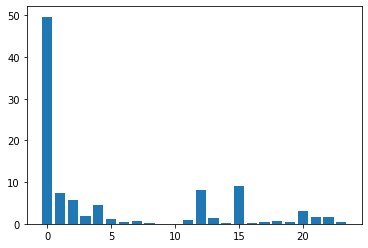

In [186]:
feature_importances = pd.DataFrame({'features':features_test.columns,'feature_importance':model_best.feature_importances_})
print(feature_importances.sort_values('feature_importance',ascending=False))
# plot feature importance
importance = model_best.feature_importances_
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Четыре самых значимых признака - это 
+ *id* - идентификационный номер клиента;
+ *country* — гражданство постояльца;  
+ *previous_cancellations* — количество подтверждённых заказов у клиента;
+ *lead_time* — количество дней между датой бронирования и датой прибытия. 

Получим рейтинг 10 стран с самой высокой и самой низкой долей отказов от брони:

In [187]:
df_test_filt_country = df_test.groupby('country')['is_canceled'].agg(['mean', 'count']).sort_values('mean', ascending=False)
df_test_filt_country = df_test_filt_country.query('count > 10').reset_index()
list_country_bad = list(df_test_filt_country['country'][:11])
display('Рейтинг 10 "Плохих" стран:', df_test_filt_country.head(10))
print('-------------------------------------------------------------------------')
display('Рейтинг 10  "Хороших" стран:', df_test_filt_country.tail(10))
list_country_good = list(df_test_filt_country['country'][-10:])

'Рейтинг 10 "Плохих" стран:'

,country,mean,count
0,MAC,0.928571,14
1,ARE,0.909091,11
2,HKG,0.750000,12
3,PHL,0.640000,25
4,SGP,0.615385,13
5,PRT,0.596035,9887
6,SAU,0.545455,11
7,KOR,0.516667,60
8,NGA,0.500000,12
9,CHN,0.493671,395


-------------------------------------------------------------------------


'Рейтинг 10  "Хороших" стран:'

,country,mean,count
55,DZA,0.173913,23
56,CHL,0.166667,12
57,NZL,0.166667,18
58,LTU,0.150000,20
59,JPN,0.147059,68
60,SVK,0.133333,15
61,SRB,0.133333,15
62,MEX,0.090909,33
63,BGR,0.041667,24
64,ISL,0.035714,28


In [199]:
print(len(df_test))
print(df_test['id'].nunique())

32412
32412


Повторяющихся *id* нет. Поэтому сгруппировать не получится.

In [201]:
df_test_previous_cancel = df_test.groupby('previous_cancellations')['is_canceled'].agg(['mean', 'count']).sort_values('mean', ascending=False)
display('Доля от отказов от брони при количестве подтверждённых заказов у клиента:', df_test_previous_cancel)

'Доля от отказов от брони при количестве подтверждённых заказов у клиента:'

,mean,count
previous_cancellations,,
0,0.390108,32186
3,0.333333,6
4,0.300000,10
1,0.157576,165
2,0.137931,29
5,0.000000,1
6,0.000000,15


Мы видим самый высокий процент отказов от брони(почти 40%) у клиентов, которые бронируют номер впервые. Процент отказов у бронирующих 2-ой и 3-ий раз - немногим больше 10%. Бронирующие 4-ый и 5-ый раз имеют процент отказов больше 30% - объяснение этому мы найти не можем, просто примем как факт. Те кто бронируют 6-ой и 7-ой раз - отказов от брони не имеют.  

In [202]:
df_test_filt_lead_time = df_test.groupby('lead_time')['is_canceled'].agg(['mean', 'count']).reset_index().sort_values('lead_time', ascending=True)
display('Закономерность увеличения вероятности отказа от брони с увеличением времени между бронированием из заездом:', df_test_filt_lead_time.head(10))
print('-------------------------------------------------------------------------------')
display('Значение lead_time при вероятности от отказа от брони больше 50%: ', df_test_filt_lead_time.query('mean > 0.5'))

'Закономерность увеличения вероятности отказа от брони с увеличением времени между бронированием из заездом:'

,lead_time,mean,count
0,0.0,0.056686,1376
1,1.0,0.060026,783
2,2.0,0.101626,492
3,3.0,0.089330,403
4,4.0,0.081841,391
5,5.0,0.136232,345
6,6.0,0.161202,366
7,7.0,0.100796,377
8,8.0,0.196552,290
9,9.0,0.228814,236


-------------------------------------------------------------------------------


'Значение lead_time при вероятности от отказа от брони больше 50%: '

,lead_time,mean,count
28,28.0,0.555911,313
37,37.0,0.556452,124
38,38.0,0.690265,226
52,52.0,0.633136,169
54,54.0,0.637584,149
...,...,...,...
362,365.0,1.000000,2
363,366.0,1.000000,1
365,368.0,0.805556,36
366,372.0,1.000000,11


Исходя из выше представленных рассчетов можно составить портрет "Ненадежного клиента" и "Надежного клиета":
- "Ненадежный клиент":
  + Приезжает из стран: 'MAC', 'HKG', 'ARE', 'NGA', 'QAT', 'DOM', 'IDN', 'PRT', 'PHL', 'SAU'
  + Бронирует номер первый раз, а так же четвертый или пятый раз.
  + Бронирует номер за 30 дней и более до заезда.
- "Надежный клиент":
  + Приезжает из стран: 'MYS', 'BGR', 'JPN', 'DZA', 'MEX', 'NZL', 'ISL', 'CRI', 'SRB', 'IRQ'
  + Бронирует номер второй или третий раз.
  + Бронирует номер за менее чем 30 дней до заезда.

 

### Общий вывод:

1. Внедрение модели дает прибыль только при низком оттоке клиентов:
  - При оптимистичном сценарии - около 7 млн. за весь период.
  - При пессимистичном сценарии - около (-5800) за весь период. 
 -  **Перед внедрением модели провести A/B тест на отток клиентов при предложении о внесении депозита при бронировании номера. Рекомендумый отток - не более 30%**
2. Окупаемость наступает на сроке:
  - При оптимистичном сценарии - 4 месяца.
  - При пессимистичном сценарии - нет.
3. Портреты клиетов:
- "Ненадежный клиент":
  + Приезжает из стран: 'MAC', 'HKG', 'ARE', 'NGA', 'QAT', 'DOM', 'IDN', 'PRT', 'PHL', 'SAU'
  + Бронирует номер первый раз, а так же четвертый или пятый раз.
  + Бронирует номер за 30 дней и более до заезда.
- "Надежный клиент":
  + Приезжает из стран: 'MYS', 'BGR', 'JPN', 'DZA', 'MEX', 'NZL', 'ISL', 'CRI', 'SRB', 'IRQ'
  + Бронирует номер второй или третий раз.
  + Бронирует номер за менее чем 30 дней до заезда.

<div style="border:solid green 2px; padding: 20px">
<b>Комментарий ревьюера:</b>    
    
Александр, ты провел превосходное исследование, нет слов! 👏👏👏 
    
Отдельное спасибо за очень качественное оформление проекта, проверять такой проект – одно удовольствие! :)
    
Доработать нужно следующее:
    
- разобраться с OneHotEncoder;
- корректно рассчитать прибыль при пессимистическом сценарии;
- исправить желтые замечания (если их больше двух).

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Приятно слышать))
Все замечания исправил.
Благодарю за качественное ревью)
</div> 